## Quantative Finance project 

The purpose of this project was to recreate a long only moving-average quantative strategy which would allow me to showcase my ability in coding while also learning about various models and ideas in quantative finance.

The project itself recreates a situation where an investor seeks over a year from 21-02-2018 to invest a sum N of capital in the S&P500. To make the project less computationally intensive, only the first 50 companies in the S&P500, arranged alphabetically by ticker, will be looked at.

The project therefore consists of two main parts. The signal analysis, where the historical prices of each stock are  converted into a 50 day and 20 day exponential moving averages. Stocks are considered worth investing in on a particular day if the 20 day EMA is above the 50 day EMA. The risk in the stock is calculated as the standard deviation of historic returns up to that day. The portfolio will be assembled each day so that each stock that is invested in will present the same risk to the overall protfolio.

Trading gets done daily. Each day, all pervious positions get liquidated. and the total resulting available capital get calculated. A list is created of all companies with positive crossovers on that day. Then working down the positive crossover list, an investment is calculated for the chosen stocks till no capital remains. If the calculated investment for a stock is greater than the remaining capital, then the investment is changed to be equal to the remaining capital. If the end of the list of positive crossover stocks is reached before all capital is spent then the process is iterated through again until no more capital remains.

In [191]:
!pip install pandas-datareader
import pandas as pd
import numpy as np
from pandas_datareader import data
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns
from scipy.stats import norm

sns.set(style='darkgrid', context='talk', palette='Dark2')

You are using pip version 19.0.2, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


To start with, we fetch a list of all the S&P500 tickers by scraping and processing the HTML from the S&P500 Wikipedia page which is kept relatively up to date and has an easy strucutre to understand:

In [7]:
SP500Wiki = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
WikiTable = SP500Wiki[0]
WikiTable.head()

,0,1,2,3,4,5,6,7,8
0,Security,Symbol,SEC filings,GICS Sector,GICS Sub Industry,Headquarters Location,Date first added[3][4],CIK,Founded
1,3M Company,MMM,reports,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",NaN,0000066740,1902
2,Abbott Laboratories,ABT,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,0000001800,1888
3,AbbVie Inc.,ABBV,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,0001551152,2013 (1888)
4,ABIOMED Inc,ABMD,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,0000815094,1981


In [8]:
sliced_table = WikiTable[1:]
header = WikiTable.iloc[0]
corrected_table = sliced_table.rename(columns=header)
corrected_table

,Security,Symbol,SEC filings,GICS Sector,GICS Sub Industry,Headquarters Location,Date first added[3][4],CIK,Founded
1,3M Company,MMM,reports,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",NaN,0000066740,1902
2,Abbott Laboratories,ABT,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,0000001800,1888
3,AbbVie Inc.,ABBV,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,0001551152,2013 (1888)
4,ABIOMED Inc,ABMD,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,0000815094,1981
5,Accenture plc,ACN,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,0001467373,1989
6,Activision Blizzard,ATVI,reports,Communication Services,Interactive Home Entertainment,"Santa Monica, California",2015-08-31,0000718877,2008
7,Adobe Systems Inc,ADBE,reports,Information Technology,Application Software,"San Jose, California",1997-05-05,0000796343,1982
8,Advanced Micro Devices Inc,AMD,reports,Information Technology,Semiconductors,"Sunnyvale, California",2017-03-20,0000002488,1969
9,Advance Auto Parts,AAP,reports,Consumer Discretionary,Automotive Retail,"Roanoke, Virginia",2015-07-09,0001158449,1932
10,AES Corp,AES,reports,Utilities,Independent Power Producers & Energy Traders,"Arlington, Virginia",1998-10-02,0000874761,1981


Now that we have a list of all the tickers, we use Pandas.DataReader to fetch the historical price data from Yahoo for the first 50 tickers. The price data is collected from as early as 20-02-2000 purely to allow us the furthest lookback when calculating the standard deviation of the historic returns of a stock. 

The data is saved as two seperate sets to make things clearer. The first set, trainAC, is the set of what would be purely historical data that the system will already know. The second set, testAC, is the set of price data that will occur during our 1-year investment period.



In [15]:
tickers = corrected_table['Symbol'].tolist()
print(tickers100)
start_test_date = '2018-02-20'
end_test_date = '2019-02-20'
test_data = data.DataReader(tickers[:50], "yahoo", start_test_date, end_test_date)
start_train_date = '2000-02-20'
end_train_date = '2018-02-20'
train_data = data.DataReader(tickers[:50], 'yahoo', start_train_date, end_train_date)





['MMM', 'ABT', 'ABBV', 'ABMD', 'ACN', 'ATVI', 'ADBE', 'AMD', 'AAP', 'AES', 'AMG', 'AFL', 'A', 'APD', 'AKAM', 'ALK', 'ALB', 'ARE', 'ALXN', 'ALGN', 'ALLE', 'AGN', 'ADS', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AEE', 'AAL', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'ABC', 'AME', 'AMGN', 'APH', 'APC', 'ADI', 'ANSS', 'ANTM', 'AON', 'AOS', 'APA', 'AIV', 'AAPL', 'AMAT', 'APTV', 'ADM', 'ARNC', 'ANET', 'AJG', 'AIZ', 'ATO', 'T', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'BHGE', 'BLL', 'BAC', 'BK', 'BAX', 'BBT', 'BDX', 'BRK.B', 'BBY', 'BIIB', 'BLK', 'HRB', 'BA', 'BKNG', 'BWA', 'BXP', 'BSX', 'BHF', 'BMY', 'AVGO', 'BR', 'BF.B', 'CHRW', 'COG', 'CDNS', 'CPB', 'COF', 'CPRI', 'CAH', 'KMX', 'CCL', 'CAT', 'CBOE', 'CBRE', 'CBS', 'CE']


In [193]:
testAC.head()

,Adj Close A,Adj Close AAL,Adj Close AAP,Adj Close AAPL,Adj Close ABBV,Adj Close ABC,Adj Close ABMD,Adj Close ABT,Adj Close ACN,Adj Close ADBE,...,Adj Close APH,Adj Close ARE,Adj Close ATVI,Adj Close AWK,Adj Close AXP,Adj Close GOOG,Adj Close GOOGL,Adj Close LNT,Adj Close MMM,Adj Close MO
Date,,,,,,,,,,,,,,,,,,,,,
2018-02-20,70.427200,51.183826,105.172073,169.272461,112.980812,98.167488,270.480011,58.064407,158.578491,202.979996,...,89.489143,117.275368,70.476662,78.231331,95.741318,1102.459961,1103.589966,37.919891,228.764038,60.935673
2018-02-21,70.595634,52.232834,113.807465,168.504166,112.913780,96.821785,268.250000,57.936729,157.615860,202.089996,...,89.548569,114.812935,69.859848,77.251602,96.046700,1111.339966,1113.750000,37.416100,225.951553,60.688854
2018-02-22,70.030869,52.430759,110.303398,169.912704,112.578606,95.397507,263.970001,57.936729,157.478348,202.610001,...,89.360397,116.305908,69.133583,77.143837,95.898933,1106.630005,1109.900024,37.396721,229.669098,60.128769
2018-02-23,70.050682,52.836510,116.123550,172.867706,113.718185,96.674446,268.450012,58.643871,160.061722,209.740005,...,89.954628,118.904053,71.700356,78.995514,97.327324,1126.790039,1128.089966,38.191158,230.661743,61.315384
2018-02-26,69.931793,54.429825,114.656036,176.285675,116.389961,98.796143,273.179993,59.449230,161.820007,212.149994,...,91.519386,119.611755,72.784767,79.162071,100.125000,1143.750000,1143.699951,38.297729,237.590729,62.112801


The trainAC and testAC dataframes are now adjusted so that they only contain the adjusted close price for each day 

In [163]:
trainAC = train_data[['Adj Close']]
trainAC.columns = [' '.join(col).strip() for col in trainAC.columns.values]
trainAC.head()

,Adj Close A,Adj Close AAL,Adj Close AAP,Adj Close AAPL,Adj Close ABBV,Adj Close ABC,Adj Close ABMD,Adj Close ABT,Adj Close ACN,Adj Close ADBE,...,Adj Close APH,Adj Close ARE,Adj Close ATVI,Adj Close AWK,Adj Close AXP,Adj Close GOOG,Adj Close GOOGL,Adj Close LNT,Adj Close MMM,Adj Close MO
Date,,,,,,,,,,,,,,,,,,,,,
2000-02-22,56.915501,NaN,NaN,2.710376,NaN,3.089604,36.937500,6.458304,NaN,24.203232,...,3.954837,14.959162,1.013492,NaN,31.008039,NaN,NaN,2.936882,26.063425,1.777678
2000-02-23,61.580696,NaN,NaN,2.768424,NaN,3.040562,35.554649,6.216419,NaN,24.534161,...,4.020692,15.022017,0.989813,NaN,30.785164,NaN,NaN,2.887934,27.044128,1.729776
2000-02-24,66.401421,NaN,NaN,2.743492,NaN,2.942480,35.625000,6.143853,NaN,26.196444,...,4.100414,14.833460,0.994549,NaN,28.974264,NaN,NaN,2.845105,26.659605,1.708487
2000-02-25,67.256691,NaN,NaN,2.628514,NaN,2.746313,37.625000,6.204327,NaN,24.257103,...,4.100414,14.770611,0.966133,NaN,27.804150,NaN,NaN,2.783919,25.121546,1.671231
2000-02-28,62.824730,NaN,NaN,2.696980,NaN,2.844396,37.000000,6.409926,NaN,24.087805,...,4.159337,14.959162,0.951925,NaN,29.559322,NaN,NaN,2.777801,25.322964,1.708487


In [164]:
testAC = test_data[['Adj Close']]
testAC.columns = [' '.join(col).strip() for col in testAC.columns.values]
testAC.head()

,Adj Close A,Adj Close AAL,Adj Close AAP,Adj Close AAPL,Adj Close ABBV,Adj Close ABC,Adj Close ABMD,Adj Close ABT,Adj Close ACN,Adj Close ADBE,...,Adj Close APH,Adj Close ARE,Adj Close ATVI,Adj Close AWK,Adj Close AXP,Adj Close GOOG,Adj Close GOOGL,Adj Close LNT,Adj Close MMM,Adj Close MO
Date,,,,,,,,,,,,,,,,,,,,,
2018-02-20,70.427200,51.183826,105.172073,169.272461,112.980812,98.167488,270.480011,58.064407,158.578491,202.979996,...,89.489143,117.275368,70.476662,78.231331,95.741318,1102.459961,1103.589966,37.919891,228.764038,60.935673
2018-02-21,70.595634,52.232834,113.807465,168.504166,112.913780,96.821785,268.250000,57.936729,157.615860,202.089996,...,89.548569,114.812935,69.859848,77.251602,96.046700,1111.339966,1113.750000,37.416100,225.951553,60.688854
2018-02-22,70.030869,52.430759,110.303398,169.912704,112.578606,95.397507,263.970001,57.936729,157.478348,202.610001,...,89.360397,116.305908,69.133583,77.143837,95.898933,1106.630005,1109.900024,37.396721,229.669098,60.128769
2018-02-23,70.050682,52.836510,116.123550,172.867706,113.718185,96.674446,268.450012,58.643871,160.061722,209.740005,...,89.954628,118.904053,71.700356,78.995514,97.327324,1126.790039,1128.089966,38.191158,230.661743,61.315384
2018-02-26,69.931793,54.429825,114.656036,176.285675,116.389961,98.796143,273.179993,59.449230,161.820007,212.149994,...,91.519386,119.611755,72.784767,79.162071,100.125000,1143.750000,1143.699951,38.297729,237.590729,62.112801


The concatenation of trainAC and testAC is what is mainly in this project and is called all_data. The previous two will be used as frames for when we need to restrict the size of a dataset. 

In [165]:
all_data = pd.concat([trainAC,testAC])
all_data

,Adj Close A,Adj Close AAL,Adj Close AAP,Adj Close AAPL,Adj Close ABBV,Adj Close ABC,Adj Close ABMD,Adj Close ABT,Adj Close ACN,Adj Close ADBE,...,Adj Close APH,Adj Close ARE,Adj Close ATVI,Adj Close AWK,Adj Close AXP,Adj Close GOOG,Adj Close GOOGL,Adj Close LNT,Adj Close MMM,Adj Close MO
Date,,,,,,,,,,,,,,,,,,,,,
2000-02-22,56.915501,NaN,NaN,2.710376,NaN,3.089604,36.937500,6.458304,NaN,24.203232,...,3.954837,14.959162,1.013492,NaN,31.008039,NaN,NaN,2.936882,26.063425,1.777678
2000-02-23,61.580696,NaN,NaN,2.768424,NaN,3.040562,35.554649,6.216419,NaN,24.534161,...,4.020692,15.022017,0.989813,NaN,30.785164,NaN,NaN,2.887934,27.044128,1.729776
2000-02-24,66.401421,NaN,NaN,2.743492,NaN,2.942480,35.625000,6.143853,NaN,26.196444,...,4.100414,14.833460,0.994549,NaN,28.974264,NaN,NaN,2.845105,26.659605,1.708487
2000-02-25,67.256691,NaN,NaN,2.628514,NaN,2.746313,37.625000,6.204327,NaN,24.257103,...,4.100414,14.770611,0.966133,NaN,27.804150,NaN,NaN,2.783919,25.121546,1.671231
2000-02-28,62.824730,NaN,NaN,2.696980,NaN,2.844396,37.000000,6.409926,NaN,24.087805,...,4.159337,14.959162,0.951925,NaN,29.559322,NaN,NaN,2.777801,25.322964,1.708487
2000-02-29,64.613083,NaN,NaN,2.729725,NaN,2.856657,36.968750,6.385740,NaN,25.119040,...,4.433159,15.367716,0.961397,NaN,29.907572,NaN,NaN,2.753327,25.835648,1.719132
2000-03-01,67.878708,NaN,NaN,3.103313,NaN,2.917958,33.625000,6.542961,NaN,24.718853,...,4.741646,15.399149,1.098739,NaN,30.200087,NaN,NaN,2.728853,25.231415,1.740421
2000-03-02,65.497505,NaN,NaN,2.905356,NaN,2.930219,32.312500,6.482491,NaN,19.855124,...,4.561407,15.084875,1.098739,NaN,29.768286,NaN,NaN,2.692141,25.213106,1.713809
2000-03-03,67.178940,NaN,NaN,3.048243,NaN,2.807616,33.875000,6.276890,NaN,22.317768,...,4.551008,15.179157,1.122419,NaN,29.754345,NaN,NaN,2.686023,26.220152,1.729776


Using the all_data Dataframe we can calculate the returns for each stock, the standard deviation of which will then be used to represent the risk associated with that stock

In [166]:
returns = all_data.pct_change(1)
returns.shape

(4780, 50)

As some of the stocks do not contain data before a certain date we will constrain the start of our returns dataframe for all stocks to that of the stock for which we have the least data. 

To do this we find the index for each stock at which occurs the first cell of vailid data. We assume for each stock that after this date there are no other occurances of missing data. We then take the largest returned index and use this to crop our dataframe to only include data after this date. 

In [167]:
VI = []
for i in range(len(returns.columns.values)):
    VI.append(returns[returns.columns.values[i]]. first_valid_index())
    
FVI = max(VI)
print(FVI)




2013-11-19 00:00:00


In [168]:
for i in range(len(returns)):
    
    if (returns.iloc[[i]].index.year[0] == FVI.year and returns.iloc[[i]].index.month[0] == FVI.month and returns.iloc[[i]].index.day[0] == FVI.day ):
        firstIndex = i 
        print(i)


3458


In [203]:
returnsSD = returns.iloc[firstIndex:]
returnsSD

,Adj Close A,Adj Close AAL,Adj Close AAP,Adj Close AAPL,Adj Close ABBV,Adj Close ABC,Adj Close ABMD,Adj Close ABT,Adj Close ACN,Adj Close ADBE,...,Adj Close APH,Adj Close ARE,Adj Close ATVI,Adj Close AWK,Adj Close AXP,Adj Close GOOG,Adj Close GOOGL,Adj Close LNT,Adj Close MMM,Adj Close MO
Date,,,,,,,,,,,,,,,,,,,,,
2013-11-19,-0.004256,-0.006967,-0.012715,0.001774,-0.008389,-0.004049,0.010004,0.020295,-0.000637,-0.014664,...,-0.001651,-0.010676,-0.035959,-0.011833,0.001457,-0.006156,-0.006156,-0.003191,-0.000615,-0.005259
2013-11-20,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2013-11-21,0.002128,0.003484,0.006357,0.000887,0.004195,0.002025,0.005002,0.010148,0.000318,0.007332,...,0.000825,0.005338,0.017980,0.005917,0.000729,0.003078,0.003078,0.001595,0.000307,0.002630
2013-11-22,0.002654,0.004345,0.007929,0.000724,0.005232,0.002525,0.004084,0.008286,0.000397,0.009145,...,0.001030,0.006658,0.022424,0.007379,0.000595,0.003839,0.003839,0.001990,0.000383,0.003280
2013-11-25,0.002721,0.004455,0.008129,0.000631,0.005364,0.002589,0.003559,0.007221,0.000407,0.009376,...,0.001056,0.006826,0.022990,0.007566,0.000518,0.003936,0.003936,0.002040,0.000393,0.003362
2013-11-26,0.002645,0.004330,0.007902,0.000571,0.005214,0.002516,0.003220,0.006533,0.000396,0.009114,...,0.001026,0.006635,0.022348,0.007354,0.000469,0.003826,0.003826,0.001983,0.000382,0.003268
2013-11-27,0.002526,0.004136,0.007548,0.000528,0.004980,0.002404,0.002980,0.006045,0.000378,0.008705,...,0.000980,0.006338,0.021347,0.007025,0.000434,0.003654,0.003654,0.001894,0.000365,0.003122
2013-11-29,0.002400,0.003930,0.007172,0.000496,0.004732,0.002284,0.002798,0.005676,0.000359,0.008272,...,0.000931,0.006022,0.020284,0.006675,0.000408,0.003472,0.003472,0.001800,0.000347,0.002967
2013-12-02,0.002280,0.003733,0.006813,0.000471,0.004495,0.002170,0.002653,0.005383,0.000341,0.007857,...,0.000885,0.005720,0.019267,0.006340,0.000387,0.003298,0.003298,0.001710,0.000329,0.002818


We know use the returns Dataframe to construct a new dataframe called returnsSD which will hold the standard deviations of each stock calculated using all the returns upt to the date of the current cell. This is to recreate a system that updates its risk calculations to include the previous day's returns. 

considering we will also be using returnsSD to calculate our investments we also work out the index in returnsSD, referred to as the dropIndex, at which the first date in our testAC dataframe occurs. this will allow us to later crop returnsSD to the same size as testAC. Having both dataframes with the same dimensions will make mapping the two onto each other later easier. 

In [204]:
for i in range(0, len(returnsSD)):
    
    if (returnsSD.iloc[[i]].index.year[0] == testAC.index[0].year and returnsSD.iloc[[i]].index.month[0] == testAC.index[0].month and returnsSD.iloc[[i]].index.day[0] == testAC.index[0].day ):
        dropIndex = i
        
print(dropIndex)
print(returnsSD.iloc[[dropIndex]].index)

1070
DatetimeIndex(['2018-02-20'], dtype='datetime64[ns]', name='Date', freq=None)


In [171]:
for i in range(1,len(returnsSD)):
    for j in range(len(returns.columns.values)):
        returnsSD.iat[i,j] = np.std(returnsSD[returnsSD.columns.values[j]].values[0:i])
      

In [205]:
returnsSD

,Adj Close A,Adj Close AAL,Adj Close AAP,Adj Close AAPL,Adj Close ABBV,Adj Close ABC,Adj Close ABMD,Adj Close ABT,Adj Close ACN,Adj Close ADBE,...,Adj Close APH,Adj Close ARE,Adj Close ATVI,Adj Close AWK,Adj Close AXP,Adj Close GOOG,Adj Close GOOGL,Adj Close LNT,Adj Close MMM,Adj Close MO
Date,,,,,,,,,,,,,,,,,,,,,
2013-11-19,-0.004256,-0.006967,-0.012715,0.001774,-0.008389,-0.004049,0.010004,0.020295,-0.000637,-0.014664,...,-0.001651,-0.010676,-0.035959,-0.011833,0.001457,-0.006156,-0.006156,-0.003191,-0.000615,-0.005259
2013-11-20,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2013-11-21,0.002128,0.003484,0.006357,0.000887,0.004195,0.002025,0.005002,0.010148,0.000318,0.007332,...,0.000825,0.005338,0.017980,0.005917,0.000729,0.003078,0.003078,0.001595,0.000307,0.002630
2013-11-22,0.002654,0.004345,0.007929,0.000724,0.005232,0.002525,0.004084,0.008286,0.000397,0.009145,...,0.001030,0.006658,0.022424,0.007379,0.000595,0.003839,0.003839,0.001990,0.000383,0.003280
2013-11-25,0.002721,0.004455,0.008129,0.000631,0.005364,0.002589,0.003559,0.007221,0.000407,0.009376,...,0.001056,0.006826,0.022990,0.007566,0.000518,0.003936,0.003936,0.002040,0.000393,0.003362
2013-11-26,0.002645,0.004330,0.007902,0.000571,0.005214,0.002516,0.003220,0.006533,0.000396,0.009114,...,0.001026,0.006635,0.022348,0.007354,0.000469,0.003826,0.003826,0.001983,0.000382,0.003268
2013-11-27,0.002526,0.004136,0.007548,0.000528,0.004980,0.002404,0.002980,0.006045,0.000378,0.008705,...,0.000980,0.006338,0.021347,0.007025,0.000434,0.003654,0.003654,0.001894,0.000365,0.003122
2013-11-29,0.002400,0.003930,0.007172,0.000496,0.004732,0.002284,0.002798,0.005676,0.000359,0.008272,...,0.000931,0.006022,0.020284,0.006675,0.000408,0.003472,0.003472,0.001800,0.000347,0.002967
2013-12-02,0.002280,0.003733,0.006813,0.000471,0.004495,0.002170,0.002653,0.005383,0.000341,0.007857,...,0.000885,0.005720,0.019267,0.006340,0.000387,0.003298,0.003298,0.001710,0.000329,0.002818


As mentioned before, we now limit the dimensions of the dataframe to that of trainAC:

In [206]:
returnsSD = returnsSD.drop(returnsSD.index[:dropIndex])
returnsSD

,Adj Close A,Adj Close AAL,Adj Close AAP,Adj Close AAPL,Adj Close ABBV,Adj Close ABC,Adj Close ABMD,Adj Close ABT,Adj Close ACN,Adj Close ADBE,...,Adj Close APH,Adj Close ARE,Adj Close ATVI,Adj Close AWK,Adj Close AXP,Adj Close GOOG,Adj Close GOOGL,Adj Close LNT,Adj Close MMM,Adj Close MO
Date,,,,,,,,,,,,,,,,,,,,,
2018-02-21,0.000312,0.000511,0.000933,0.000082,0.000616,0.000297,0.000465,0.000944,0.000047,0.001076,...,0.000121,0.000784,0.002639,0.000869,0.000068,0.000452,0.000452,0.000234,0.000045,0.000386
2018-02-22,0.000312,0.000511,0.000933,0.000082,0.000616,0.000297,0.000465,0.000944,0.000047,0.001076,...,0.000121,0.000783,0.002638,0.000868,0.000068,0.000452,0.000452,0.000234,0.000045,0.000386
2018-02-23,0.000312,0.000511,0.000933,0.000082,0.000615,0.000297,0.000465,0.000943,0.000047,0.001076,...,0.000121,0.000783,0.002638,0.000868,0.000068,0.000452,0.000452,0.000234,0.000045,0.000386
2018-02-26,0.000312,0.000511,0.000932,0.000082,0.000615,0.000297,0.000465,0.000943,0.000047,0.001075,...,0.000121,0.000783,0.002637,0.000868,0.000068,0.000451,0.000451,0.000234,0.000045,0.000386
2018-02-27,0.000312,0.000511,0.000932,0.000082,0.000615,0.000297,0.000465,0.000943,0.000047,0.001075,...,0.000121,0.000783,0.002636,0.000867,0.000068,0.000451,0.000451,0.000234,0.000045,0.000385
2018-02-28,0.000312,0.000511,0.000932,0.000082,0.000615,0.000297,0.000464,0.000942,0.000047,0.001075,...,0.000121,0.000782,0.002635,0.000867,0.000068,0.000451,0.000451,0.000234,0.000045,0.000385
2018-03-01,0.000312,0.000510,0.000931,0.000082,0.000615,0.000297,0.000464,0.000942,0.000047,0.001074,...,0.000121,0.000782,0.002634,0.000867,0.000068,0.000451,0.000451,0.000234,0.000045,0.000385
2018-03-02,0.000312,0.000510,0.000931,0.000082,0.000614,0.000297,0.000464,0.000942,0.000047,0.001074,...,0.000121,0.000782,0.002633,0.000867,0.000068,0.000451,0.000451,0.000234,0.000045,0.000385
2018-03-05,0.000312,0.000510,0.000931,0.000082,0.000614,0.000296,0.000464,0.000941,0.000047,0.001073,...,0.000121,0.000782,0.002632,0.000866,0.000068,0.000451,0.000451,0.000234,0.000045,0.000385


We now also workout the index for all_data which will allow us to crop any subsequent dataframes of the same size so that they have the same date range as testAC. The reason we do this rather than use testAC is that when calculating our 50 day and 20 day exponential moving averages, we will need data before the testAC start date to establish the moving avergae for that date.

In [208]:
for i in range(len(all_data)):
    
    if (all_data.iloc[[i]].index.year[0] == testAC.index[0].year and all_data.iloc[[i]].index.month[0] == testAC.index[0].month and all_data.iloc[[i]].index.day[0] == testAC.index[0].day ):
        ADIndex = i 
print(ADIndex)

4528


Now that we have all of our constituent dataframes, what we need is to create the crossover signal between the 20 day and 50 day EMA. This will be our indicator of which stocks are likely trending upwards.

An example of this crossover for Abiomed (ABMD) is shown in the timeseries graph below. 

We also define our positions dataframe which is initially blank and a returns multiplier dataframe which will allow us to calculate the change in value of our previous days positions.  

In [185]:
ema_20 = all_data.ewm(span=20, adjust=False).mean()
ema_20Test = ema_20.drop(ema_20.index[:ADIndex])
ema_50 = all_data.ewm(span=50, adjust=False).mean()
ema_50Test = ema_50.drop(ema_50.index[:ADIndex])
ema_cross = ema_20Test - ema_50Test
positions = testAC.copy()
positions[:] = 0
returnsRedacted = returns[ADIndex:]
returnsMultiplier = returnsRedacted +1


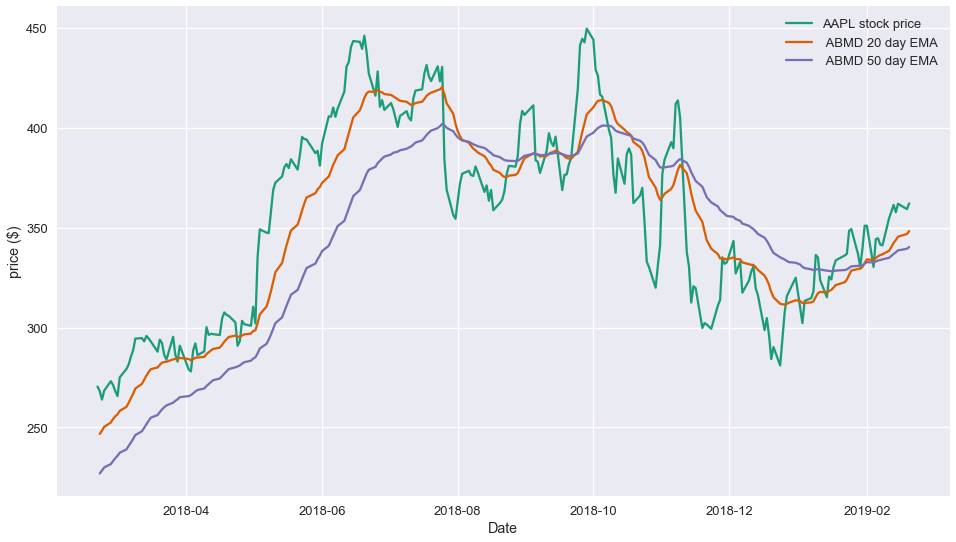

In [186]:
fig, ax1 = plt.subplots(figsize=(16,9))

ax1.plot(testAC.index, testAC.loc[:, 'Adj Close ABMD'], label="ABMD stock price")
ax1.plot(ema_20Test.index, ema_20Test.loc[:, 'Adj Close ABMD'], label=' ABMD 20 day EMA')
ax1.plot(ema_50Test.index, ema_50Test.loc[:, 'Adj Close ABMD'], label=' ABMD 50 day EMA')

ax1.set_xlabel('Date')
ax1.set_ylabel('price ($)')
ax1.legend()

This section is now where we bring together all the previoulsy created Dataframes to produce our positions dataframe which will list the value invested in each stock each day over the year.

It works by iterating through each day of the year and calculating the list of positive crossover stocks, ordered from largest to smallest positive crossover. For each day of the year it then iterates through the list and calculates the amount that day to invest for the stock based on investing enough in each stock so that they each pose the same risk to the portfolio. More precisely they each are expected to lose the same amount over a given time frame for a given confidence level.

This is done by calculating the product of the capital (N) available that day, the desired risk (scaledRisk) and the inverse of the standard deviation of that stocks historic returns up to that day.

The resulting quantity is then inputed into the column for that stock on that day in the positions dataFrame. 

The capital available each day is calculated as the total worth of the positions being held the previous day once adjusted for any returns or losses they have made. On the first day (i=0), N is simply what it was originally assigned to be.

In [187]:
N = 1000000
scaledRisk = 0.00005
spentCapital = 0
Totalpositions = 0

for i in range(0,len(ema_cross)):
    if i == 0:
        priorityList = ema_cross.iloc[[i]].transpose()
        priorityListOrd = priorityList.sort_values(by=[priorityList.columns.values[0]], ascending=False)
        priorityListOrd = priorityListOrd.reset_index()
        
        for k in range(len(priorityListOrd)):
            if priorityListOrd.iat[k,1] <=0:
                PDI = k
                break
        investOpp = priorityListOrd[0:k-1]
        
        while spentCapital < N:
            for j in range(len(investOpp)):
                stockAlloc = N* scaledRisk /returnsSD[[investOpp.iat[j,0]]].iat[i,0]
                
                if stockAlloc < (N-spentCapital):
                    positions.at[positions.index[i],investOpp.iat[j,0]] += stockAlloc
                    spentCapital += stockAlloc
                    print(stockAlloc)
                    print(spentCapital)
                    print(investOpp.iat[j,0])
                    print('if')
                    print("i=0")
                    print()
                
                elif stockAlloc >= (N - spentCapital):
                    positions.at[positions.index[i],investOpp.iat[j,0]] += (N-spentCapital)
                    print(N-spentCapital)
                    spentCapital += (N-spentCapital)
                    print(spentCapital)
                    print(investOpp.iat[j,0])
                    print('elif')
                    print("i=0")
                    print()
                    
                    break
    else:
        NRaw = positions.iloc[[0]]
        NRaw[:] = 0
        for j in range(len(NRaw.columns.values)):
            NRaw.at[NRaw.index[0],NRaw.columns.values[j]] = positions.iat[i-1,j] * returnsMultiplier.iat[i,j]
        N = np.sum(NRaw.values)
        print("----------------------------")
        print("Total PF worth at start of " , positions.index[i].year , " " , positions.index[i].month , " " , positions.index[i].day , ": " , N)
        print("----------------------------")
        
        spentCapital = 0
        
        priorityList = ema_cross.iloc[[i]].transpose()
        priorityListOrd = priorityList.sort_values(by=[priorityList.columns.values[0]], ascending=False)
        priorityListOrd = priorityListOrd.reset_index()
        
        for l in range(len(priorityListOrd)):
            if priorityListOrd.iat[l,1] <=0:
                PDI = l
                break
        investOpp = priorityListOrd[0:l-1]
        
        while spentCapital < N:
            for m in range(len(investOpp)):
                stockAlloc = N* scaledRisk /returnsSD[[investOpp.iat[m,0]]].iat[i,0]
                
                if stockAlloc < (N-spentCapital):
                    positions.at[positions.index[i],investOpp.iat[m,0]] += stockAlloc
                    spentCapital += stockAlloc
                    print(stockAlloc)
                    print(spentCapital)
                    print(investOpp.iat[m,0])
                    print('if')
                    print("i > 0")
                    print()
                    
                
                elif stockAlloc >= (N - spentCapital):
                    positions.at[positions.index[i],investOpp.iat[m,0]] += (N-spentCapital)
                    print(N-spentCapital)
                    spentCapital += (N-spentCapital)
                    print(spentCapital)
                    print(investOpp.iat[m,0])
                    print('elif')
                    print("i > 0")
                    print()
                    
                    break
        

    

201175.15021185696
201175.15021185696
Adj Close AMZN
if
i=0

107476.78915507314
308651.9393669301
Adj Close ABMD
if
i=0

110665.12878175043
419317.06814868056
Adj Close GOOG
if
i=0

46455.522867238855
465772.5910159194
Adj Close ADBE
if
i=0

81201.93171193793
546974.5227278573
Adj Close ABBV
if
i=0

110664.54240791245
657639.0651357698
Adj Close GOOGL
if
i=0

61260.4057005674
718899.4708363372
Adj Close ANSS
if
i=0

23581.246964188384
742480.7178005256
Adj Close ALGN
if
i=0

257519.2821994744
1000000.0
Adj Close ACN
elif
i=0



/Users/Alex/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Alex/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer(key, value)
/Users/Alex/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return self._setitem_sli

----------------------------
Total PF worth at start of  2018   2   21 :  1000411.8994280451
----------------------------
201324.31566168566
201324.31566168566
Adj Close AMZN
if
i > 0

107556.38683944858
308880.70250113425
Adj Close ABMD
if
i > 0

110747.18371595928
419627.88621709356
Adj Close GOOG
if
i > 0

46489.96826945787
466117.8544865514
Adj Close ADBE
if
i > 0

110746.5969073423
576864.4513938937
Adj Close GOOGL
if
i > 0

81262.14055312937
658126.5919470231
Adj Close ABBV
if
i > 0

61305.82848744436
719432.4204344674
Adj Close ANSS
if
i > 0

23598.73176440964
743031.1521988771
Adj Close ALGN
if
i > 0

257380.74722916808
1000411.8994280451
Adj Close ACN
elif
i > 0

----------------------------
Total PF worth at start of  2018   2   21 :  1000823.9532562059
----------------------------
201473.52655446052
201473.52655446052
Adj Close AMZN
if
i > 0

107636.00887935015
309109.53543381067
Adj Close ABMD
if
i > 0

110829.26364803429
419938.799081845
Adj Close GOOG
if
i > 0

110828.676

203241.40848384053
203241.40848384053
Adj Close AMZN
if
i > 0

108579.47079924123
311820.87928308174
Adj Close ABMD
if
i > 0

111801.76388566171
423622.64316874347
Adj Close GOOG
if
i > 0

111801.1714892121
535423.8146579555
Adj Close GOOGL
if
i > 0

46932.664841795195
582356.4794997508
Adj Close ADBE
if
i > 0

23823.44858080023
606179.928080551
Adj Close ALGN
if
i > 0

61889.607765984365
668069.5358465353
Adj Close ANSS
if
i > 0

82035.95203166502
750105.4878782004
Adj Close ABBV
if
i > 0

54128.05937626399
804233.5472544644
Adj Close AAP
if
i > 0

82823.24247723095
887056.7897316953
Adj Close AKAM
if
i > 0

118921.48099054885
1005978.2707222442
Adj Close AAPL
elif
i > 0

----------------------------
Total PF worth at start of  2018   2   21 :  1006490.8623783498
----------------------------
203411.15242246358
203411.15242246358
Adj Close AMZN
if
i > 0

108670.06324270228
312081.21566516586
Adj Close ABMD
if
i > 0

111895.13891139359
423976.35457655945
Adj Close GOOG
if
i > 0

111894.


24039.34552674487
386043.0457085795
Adj Close ALGN
if
i > 0

83573.81748501876
469616.8631935982
Adj Close AKAM
if
i > 0

62450.474395224446
532067.3375888227
Adj Close ANSS
if
i > 0

54618.58796911699
586685.9255579397
Adj Close AAP
if
i > 0

309553.1632983076
896239.0888562473
Adj Close APC
if
i > 0

115245.21868558205
1011484.3075418293
Adj Close AMT
elif
i > 0

----------------------------
Total PF worth at start of  2018   2   21 :  1011938.9601306041
----------------------------
205241.5467582115
205241.5467582115
Adj Close AMZN
if
i > 0

109646.92992198342
314888.47668019496
Adj Close ABMD
if
i > 0

47394.53833484258
362283.01501503756
Adj Close ADBE
if
i > 0

24057.89977698821
386340.91479202575
Adj Close ALGN
if
i > 0

83638.32213310427
469979.23692513
Adj Close AKAM
if
i > 0

62498.67544664056
532477.9123717706
Adj Close ANSS
if
i > 0

54660.74414795263
587138.6565197232
Adj Close AAP
if
i > 0

309791.831192233
896930.4877119563
Adj Close APC
if
i > 0

115008.47241864784
101

110654.83111156609
110654.83111156609
Adj Close ABMD
if
i > 0

207130.18542002846
317785.01653159456
Adj Close AMZN
if
i > 0

47830.66425024312
365615.68078183767
Adj Close ADBE
if
i > 0

84407.96439747569
450023.6451793134
Adj Close AKAM
if
i > 0

312639.5128865934
762663.1580659067
Adj Close APC
if
i > 0

24279.281268009938
786942.4393339166
Adj Close ALGN
if
i > 0

53252.16456728788
840194.6039012045
Adj Close ADI
if
i > 0

12688.08206908028
852882.6859702849
Adj Close ALLE
if
i > 0

164451.17626049987
1017333.8622307847
Adj Close LNT
elif
i > 0

----------------------------
Total PF worth at start of  2018   2   21 :  1017778.7093531217
----------------------------
110738.37678865281
110738.37678865281
Adj Close ABMD
if
i > 0

207286.7361748564
318025.1129635092
Adj Close AMZN
if
i > 0

47866.81507286279
365891.928036372
Adj Close ADBE
if
i > 0

24297.631755175666
390189.55979154765
Adj Close ALGN
if
i > 0

312875.5593341438
703065.1191256915
Adj Close APC
if
i > 0

84471.760654467

209216.89681842667
209216.89681842667
Adj Close AMZN
if
i > 0

111768.21111209564
320985.1079305223
Adj Close ABMD
if
i > 0

48312.52927673139
369297.63720725366
Adj Close ADBE
if
i > 0

315785.2099838334
685082.8471910871
Adj Close APC
if
i > 0

337314.2543608509
1022397.101551938
Adj Close AAPL
elif
i > 0

----------------------------
Total PF worth at start of  2018   2   21 :  1022628.8672207044
----------------------------
209330.00278601862
209330.00278601862
Adj Close AMZN
if
i > 0

111828.54883956195
321158.5516255806
Adj Close ABMD
if
i > 0

48338.647795138626
369497.19942071923
Adj Close ADBE
if
i > 0

315955.68566514127
685452.8850858605
Adj Close APC
if
i > 0

337175.98213484394
1022628.8672207044
Adj Close AAPL
elif
i > 0

----------------------------
Total PF worth at start of  2018   2   21 :  1022860.6595243594
----------------------------
209443.10601579223
209443.10601579223
Adj Close AMZN
if
i > 0

111888.88520135086
321331.9912171431
Adj Close ABMD
if
i > 0

48364.7

349233.5840382735
Adj Close ALGN
if
i > 0

116329.42376700703
465563.0078052805
Adj Close GOOGL
if
i > 0

116330.04015712807
581893.0479624085
Adj Close GOOG
if
i > 0

48833.56573256404
630726.6136949726
Adj Close ADBE
if
i > 0

396602.10298212897
1027328.7166771016
Adj Close AAPL
elif
i > 0

----------------------------
Total PF worth at start of  2018   2   21 :  1027668.7887573523
----------------------------
211608.53011391516
211608.53011391516
Adj Close AMZN
if
i > 0

113044.17188370736
324652.7019976225
Adj Close ABMD
if
i > 0

24804.22161032405
349456.92360794655
Adj Close ALGN
if
i > 0

116403.84575334683
465860.7693612934
Adj Close GOOGL
if
i > 0

116404.46253780473
582265.2318990981
Adj Close GOOG
if
i > 0

48864.807105934495
631130.0390050326
Adj Close ADBE
if
i > 0

396538.74975231965
1027668.7887573523
Adj Close AAPL
elif
i > 0

----------------------------
Total PF worth at start of  2018   2   21 :  1028008.947974886
----------------------------
211743.84459853623
21174

Adj Close AMZN
if
i > 0

114142.1523211717
327808.1727102234
Adj Close ABMD
if
i > 0

117535.65164272698
445343.8243529504
Adj Close GOOGL
if
i > 0

25045.395464318026
470389.21981726843
Adj Close ALGN
if
i > 0

117536.27442424001
587925.4942415084
Adj Close GOOG
if
i > 0

49339.924367808395
637265.4186093168
Adj Close ADBE
if
i > 0

56904.383435367534
694169.8020446843
Adj Close AAP
if
i > 0

256761.37354725244
950931.1755919368
Adj Close ADS
if
i > 0

65064.035392416736
1015995.2109843536
Adj Close ANSS
if
i > 0

17221.717279837118
1033216.9282641907
Adj Close AGN
elif
i > 0

----------------------------
Total PF worth at start of  2018   2   21 :  1033697.5765891932
----------------------------
213830.5332327346
213830.5332327346
Adj Close AMZN
if
i > 0

114229.95492131954
328060.48815405415
Adj Close ABMD
if
i > 0

25064.679247586395
353125.16740164056
Adj Close ALGN
if
i > 0

117626.14859797829
470751.31599961885
Adj Close GOOGL
if
i > 0

117626.77185900394
588378.0878586228
Adj C

Total PF worth at start of  2018   2   21 :  1038966.8852067955
----------------------------
215638.06092345275
215638.06092345275
Adj Close AMZN
if
i > 0

118620.45244003981
334258.51336349256
Adj Close GOOGL
if
i > 0

118621.08096954395
452879.5943330365
Adj Close GOOG
if
i > 0

115194.6576670753
568074.2520001119
Adj Close ABMD
if
i > 0

25276.553113839494
593350.8051139513
Adj Close ALGN
if
i > 0

259131.16466041922
852481.9697743705
Adj Close ADS
if
i > 0

57429.58510531634
909911.5548796869
Adj Close AAP
if
i > 0

65110.621596026394
975022.1764757133
Adj Close ANTM
if
i > 0

49795.30950878884
1024817.4859845021
Adj Close ADBE
if
i > 0

14149.399222293403
1038966.8852067955
Adj Close AGN
elif
i > 0

----------------------------
Total PF worth at start of  2018   2   21 :  1039447.248278539
----------------------------
215802.80174451592
215802.80174451592
Adj Close AMZN
if
i > 0

118711.0748034861
334513.876548002
Adj Close GOOGL
if
i > 0

118711.70381316736
453225.58036116936
Adj

----------------------------
Total PF worth at start of  2018   2   21 :  1045194.4991693365
----------------------------
217713.0308725516
217713.0308725516
Adj Close AMZN
if
i > 0

119761.87373230864
337474.90460486023
Adj Close GOOGL
if
i > 0

119762.50830981668
457237.41291467694
Adj Close GOOG
if
i > 0

25519.775891411384
482757.18880608835
Adj Close ALGN
if
i > 0

116302.15477569698
599059.3435817853
Adj Close ABMD
if
i > 0

65736.60396898128
664795.9475507666
Adj Close ANTM
if
i > 0

57205.47449340568
722001.4220441723
Adj Close AGN
if
i > 0

57982.19934592134
779983.6213900936
Adj Close AAP
if
i > 0

50274.46319063118
830258.0845807247
Adj Close ADBE
if
i > 0

35390.31962720163
865648.4042079264
Adj Close ALXN
if
i > 0

150072.5318601168
1015720.9360680431
Adj Close AMGN
if
i > 0

29473.563101293403
1045194.4991693365
Adj Close ADS
elif
i > 0

----------------------------
Total PF worth at start of  2018   2   21 :  1045775.0703311819
----------------------------
217898.9680061

341068.57567607146
Adj Close GOOGL
if
i > 0

121037.82406116894
462106.3997372404
Adj Close GOOG
if
i > 0

588909.4959654588
1051015.8957026992
Adj Close AAPL
elif
i > 0

----------------------------
Total PF worth at start of  2018   2   21 :  1051220.1794610159
----------------------------
220138.8996378179
220138.8996378179
Adj Close AMZN
if
i > 0

121096.32113581317
341235.22077363107
Adj Close GOOGL
if
i > 0

121096.96278410492
462332.183557736
Adj Close GOOG
if
i > 0

588887.9959032799
1051220.1794610159
Adj Close AAPL
elif
i > 0

----------------------------
Total PF worth at start of  2018   2   21 :  1051424.4785026964
----------------------------
220246.39962177633
220246.39962177633
Adj Close AMZN
if
i > 0

121155.45585757718
341401.8554793535
Adj Close GOOGL
if
i > 0

121156.09781920374
462557.95329855726
Adj Close GOOG
if
i > 0

588866.5252041391
1051424.4785026964
Adj Close AAPL
elif
i > 0

----------------------------
Total PF worth at start of  2018   2   21 :  1051628.

222251.285406383
222251.285406383
Adj Close AMZN
if
i > 0

26051.738715030133
248303.02412141312
Adj Close ALGN
if
i > 0

59190.84532364962
307493.86944506277
Adj Close AAP
if
i > 0

669491.2850172382
976985.1544623009
Adj Close AAPL
if
i > 0

67105.3113025826
1044090.4657648836
Adj Close ANTM
if
i > 0

11656.793738795794
1055747.2595036794
Adj Close ADBE
elif
i > 0

----------------------------
Total PF worth at start of  2018   2   21 :  1056023.106027262
----------------------------
222373.72984904988
222373.72984904988
Adj Close AMZN
if
i > 0

26066.091345754543
248439.82119480442
Adj Close ALGN
if
i > 0

59223.45521408684
307663.27640889125
Adj Close AAP
if
i > 0

669859.7048105361
977522.9812194274
Adj Close AAPL
if
i > 0

67142.23922901356
1044665.220448441
Adj Close ANTM
if
i > 0

11357.885578821064
1056023.106027262
Adj Close ADBE
elif
i > 0

----------------------------
Total PF worth at start of  2018   2   21 :  1056298.7108261234
----------------------------
222496.1226807

67885.06563247512
67885.06563247512
Adj Close ANTM
if
i > 0

677270.6800931896
745155.7457256647
Adj Close AAPL
if
i > 0

59879.446496354685
805035.1922220193
Adj Close AAP
if
i > 0

154983.08521341858
960018.2774354379
Adj Close AMGN
if
i > 0

59077.30627447172
1019095.5837099096
Adj Close AGN
if
i > 0

42210.17213292909
1061305.7558428387
Adj Close AON
elif
i > 0

----------------------------
Total PF worth at start of  2018   2   21 :  1061594.196019955
----------------------------
67922.78764599978
67922.78764599978
Adj Close ANTM
if
i > 0

677647.0222756168
745569.8099216166
Adj Close AAPL
if
i > 0

59912.756062964436
805482.565984581
Adj Close AAP
if
i > 0

59110.16962882142
864592.7356134024
Adj Close AGN
if
i > 0

155069.2987591736
1019662.034372576
Adj Close AMGN
if
i > 0

41932.16164737893
1061594.196019955
Adj Close AON
elif
i > 0

----------------------------
Total PF worth at start of  2018   2   21 :  1061882.549071178
----------------------------
67960.50450011114
67960.

----------------------------
Total PF worth at start of  2018   2   21 :  1067681.9845282123
----------------------------
68640.26766013968
68640.26766013968
Adj Close ANTM
if
i > 0

128691.37374215857
197331.64140229824
Adj Close AMT
if
i > 0

60546.233473542336
257877.87487584056
Adj Close AAP
if
i > 0

97640.33906381928
355518.2139396598
Adj Close AON
if
i > 0

119997.90801878426
475516.12195844407
Adj Close AEP
if
i > 0

179263.39663911072
654779.5185975548
Adj Close ALB
if
i > 0

412902.4659306576
1067681.9845282123
Adj Close AEE
elif
i > 0

----------------------------
Total PF worth at start of  2018   2   21 :  1068048.5749219675
----------------------------
68683.04485856116
68683.04485856116
Adj Close ANTM
if
i > 0

128771.65010608388
197454.69496464502
Adj Close AMT
if
i > 0

60584.00159529979
258038.69655994483
Adj Close AAP
if
i > 0

97701.24610960296
355739.9426695478
Adj Close AON
if
i > 0

120072.7614876243
475812.7041571721
Adj Close AEP
if
i > 0

475466.07407345873
95

Adj Close AEE
elif
i > 0

----------------------------
Total PF worth at start of  2018   2   21 :  1073407.412050981
----------------------------
69296.90097243685
69296.90097243685
Adj Close ANTM
if
i > 0

129923.59055310217
199220.49152553902
Adj Close AMT
if
i > 0

61125.96220403902
260346.45372957803
Adj Close AAP
if
i > 0

98575.24296391851
358921.69669349655
Adj Close AON
if
i > 0

65680.8298123086
424602.52650580514
Adj Close AWK
if
i > 0

121146.88510434297
545749.4116101481
Adj Close AEP
if
i > 0

479719.4062429153
1025468.8178530635
Adj Close AEE
if
i > 0

47938.59419791761
1073407.412050981
Adj Close A
elif
i > 0

----------------------------
Total PF worth at start of  2018   2   21 :  1073797.0842009957
----------------------------
130006.76177160937
130006.76177160937
Adj Close AMT
if
i > 0

69341.2226081721
199347.98437978147
Adj Close ANTM
if
i > 0

61165.0922860918
260513.07666587326
Adj Close AAP
if
i > 0

98638.34638522215
359151.4230510954
Adj Close AON
if
i > 0

6

----------------------------
Total PF worth at start of  2018   2   21 :  1079266.492546505
----------------------------
131245.48900186137
131245.48900186137
Adj Close AMT
if
i > 0

131245.48900186137
262490.97800372273
Adj Close AMT
if
i > 0

131245.48900186137
393736.4670055841
Adj Close AMT
if
i > 0

131245.48900186137
524981.9560074455
Adj Close AMT
if
i > 0

131245.48900186137
656227.4450093068
Adj Close AMT
if
i > 0

131245.48900186137
787472.9340111681
Adj Close AMT
if
i > 0

131245.48900186137
918718.4230130294
Adj Close AMT
if
i > 0

131245.48900186137
1049963.9120148907
Adj Close AMT
if
i > 0

29302.580531614367
1079266.492546505
Adj Close AMT
elif
i > 0

----------------------------
Total PF worth at start of  2018   2   21 :  1079710.126011623
----------------------------
131335.33111140112
131335.33111140112
Adj Close AMT
if
i > 0

122463.2586011444
253798.5897125455
Adj Close AEP
if
i > 0

131335.33111140112
385133.9208239466
Adj Close AMT
if
i > 0

122463.2586011444
507

132499.189650728
132499.189650728
Adj Close AMT
if
i > 0

161345.71701897046
293844.9066696984
Adj Close AMGN
if
i > 0

128758.85770521272
422603.76437491114
Adj Close GOOG
if
i > 0

186256.69211675425
608860.4564916654
Adj Close A
if
i > 0

60177.55343481599
669038.0099264814
Adj Close ADI
if
i > 0

128758.17545935621
797796.1853858376
Adj Close GOOGL
if
i > 0

85523.66460855519
883319.8499943927
Adj Close AFL
if
i > 0

202115.49401568237
1085435.344010075
Adj Close AIV
elif
i > 0

----------------------------
Total PF worth at start of  2018   2   21 :  1085847.1928721885
----------------------------
132585.30942502763
132585.30942502763
Adj Close AMT
if
i > 0

161450.5860130414
294035.895438069
Adj Close AMGN
if
i > 0

128842.54639639554
422878.44183446455
Adj Close GOOG
if
i > 0

60216.66671040184
483095.1085448664
Adj Close ADI
if
i > 0

186377.75236119176
669472.8609060581
Adj Close A
if
i > 0

128841.86370710339
798314.7246131615
Adj Close GOOGL
if
i > 0

85579.25195752525
88389

133750.46071991493
879980.5864638868
Adj Close AMT
if
i > 0

27695.878960039965
907676.4654239267
Adj Close ALGN
if
i > 0

74944.43389123792
982620.8993151647
Adj Close ARE
if
i > 0

109237.76072590216
1091858.6600410668
Adj Close APD
elif
i > 0

----------------------------
Total PF worth at start of  2018   2   21 :  1092465.4646922862
----------------------------
130081.86122443141
130081.86122443141
Adj Close GOOG
if
i > 0

130081.17196846557
260163.03319289698
Adj Close GOOGL
if
i > 0

71395.04626381495
331558.07945671194
Adj Close ANTM
if
i > 0

54606.36919008498
386164.4486467969
Adj Close ADBE
if
i > 0

126313.15309063313
512477.6017374301
Adj Close ABMD
if
i > 0

72008.84036930434
584486.4421067344
Adj Close ANSS
if
i > 0

101562.33831262993
686048.7804193643
Adj Close AON
if
i > 0

60795.880720341534
746844.6611397059
Adj Close ADI
if
i > 0

27718.6908727517
774563.3520124576
Adj Close ALGN
if
i > 0

133860.6252624268
908423.9772748844
Adj Close AMT
if
i > 0

75006.162420837


The resulting positions Data frame containing the invested amounts for each day can be seen below:

In [211]:
positions.tail()

,Adj Close A,Adj Close AAL,Adj Close AAP,Adj Close AAPL,Adj Close ABBV,Adj Close ABC,Adj Close ABMD,Adj Close ABT,Adj Close ACN,Adj Close ADBE,...,Adj Close APH,Adj Close ARE,Adj Close ATVI,Adj Close AWK,Adj Close AXP,Adj Close GOOG,Adj Close GOOGL,Adj Close LNT,Adj Close MMM,Adj Close MO
Date,,,,,,,,,,,,,,,,,,,,,
2019-02-13,0.0,0.0,0.0,0.0,0.0,0.0,126313.153091,0.0,0.0,54606.369190,...,0.0,75006.162421,0.0,0.0,0.0,130081.861224,130081.171968,0.0,0.0,0.0
2019-02-14,0.0,0.0,0.0,0.0,0.0,0.0,126417.098719,0.0,0.0,54651.334144,...,0.0,75067.925338,0.0,0.0,0.0,130188.975560,130188.285737,0.0,0.0,0.0
2019-02-15,0.0,0.0,0.0,0.0,0.0,0.0,126521.102317,0.0,0.0,54696.324153,...,0.0,75129.722669,0.0,0.0,0.0,130296.149579,130295.459187,0.0,0.0,0.0
2019-02-19,0.0,0.0,0.0,0.0,0.0,0.0,126625.163927,0.0,0.0,54741.339234,...,0.0,0.000000,0.0,0.0,0.0,130403.383324,130402.692365,0.0,0.0,0.0
2019-02-20,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0


In [189]:
NRaw = positions.iloc[[0]]
for j in range(len(NRaw.columns.values)):
    NRaw.at[NRaw.index[0],NRaw.columns.values[j]] = positions.iat[-2,j] * returnsMultiplier.iat[-1,j]
N = np.sum(NRaw.values)
PortfolioReturn = (N - 1000000)/1000000*100

The portfolio yearly return is therefore: 

In [212]:
PortfolioReturn

9.484576553357998


Though this project has been a great learning experience, I have had, due to time and knowledge constraints, to make certain assumptions and limitations that affect the efficiency and validity of this system.

Firstly, The EMA crossovers for each stock, which are what are used to order which stocks get priority for investment, have not been adjusted to be proportional to the price of the stock which would bias the system towards more expensive stocks.

Secondly, the risk calculations that tried to equalise the risk from each position were made slightly redundant by the fact that the system, sometimes had to loop back over the list and double the amount invested in some stocks just to spend all the available capital. This defeated the whole point that each stock would present the same risk to the portfolio, however this is more an issue with the restriction to 50 S&P500 companies as if all had been available the positive crossover list would hopefully have been long enough to make any double purchases unneccessary.

Fourthly, because my only signal is a simple EMA crossover, there can often be a lot of inefficient investing that comes from noise. A possible way to solve this might be to wait for at least two consecutive positive crossover days before investing but this could potentially also lose money by reacting slowly to positive trends and so mighnt only be effective with EMA's with longer lookbacks.

Thirdly and most importantly, This system does not take into account any of the trading costs of liquidating the entire portfolio and reinvesting it every day. Even if this process was optimised to just trade the difference in positions between days the, difference to returns would be noticeable. 